# Consumer Complaint Text Classification and Optimization

# By Jeevanantham K

This notebook performs a comprehensive text classification on the Consumer Complaint Database. The complaints are categorized into the following classes:

- **0**: Credit reporting, repair, or other
- **1**: Debt collection
- **2**: Consumer Loan
- **3**: Mortgage

The notebook covers the following steps:

1. Exploratory Data Analysis and Feature Engineering
2. Text Pre-Processing
3. Feature Extraction (TF-IDF)
4. Train-Test Split
5. Training Multiple Classification Models with Hyperparameter Optimization
    - Logistic Regression
    - Multinomial Naive Bayes
    - Linear SVC
    - Random Forest Classifier
    - Gradient Boosting Classifier
    - Multi-layer Perceptron (MLP) Classifier
6. Performance Comparison and Evaluation
7. Prediction on New Data

Note: Some columns (e.g. `Date received`, `Date sent to company`, and `Consumer disputed?`) may not be properly provided and will be dropped/ignored.

In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# NLTK for text processing
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Scikit-learn modules for feature extraction and modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# For ignoring warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JEEVANANTHAM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JEEVANANTHAM\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Load the Dataset

Assuming the dataset is stored in a CSV file named `consumer_complaints.csv`.

In [20]:
# Load the dataset
df = pd.read_csv('data/consumer_complaints.csv')
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2021-06-17,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,92324,Servicemember,Consent not provided,Web,2021-06-17,Closed with explanation,Yes,NaN,4471182
1,2024-10-25,Checking or savings account,Checking account,Opening an account,Didn't receive terms that were advertised,NaN,Company has responded to the consumer and the ...,"CITIBANK, N.A.",CA,90278,NaN,Consent not provided,Web,2024-10-25,Closed with explanation,Yes,NaN,10578376
2,2018-07-17,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",TX,77058,NaN,Consent not provided,Web,2018-07-17,Closed with explanation,Yes,NaN,2964910
3,2023-01-03,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,In accordance with the Fair Credit Reporting a...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,90022,NaN,Consent provided,Web,2023-01-03,Closed with explanation,Yes,NaN,6392293
4,2023-10-22,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,Company believes it acted appropriately as aut...,"CCS Financial Services, Inc.",GA,30310,NaN,Consent not provided,Web,2023-10-22,Closed with explanation,Yes,NaN,7740521


## 2. Exploratory Data Analysis and Feature Engineering

We perform basic checks and clean the data:

- Display dataset info and statistics
- Drop columns with problematic or incomplete data
- Map the `Product` column to our target categories. If a product is not found in the mapping, it is assigned to category **0**.

In [21]:
# Display basic information
print(df.info())
print(df.describe(include='all'))

# Drop problematic columns
df = df.drop(['Date received', 'Date sent to company', 'Consumer disputed?'], axis=1, errors='ignore')

# Define mapping for Product to Category
mapping = {
    'Credit reporting': 0,
    'Repair': 0,  # assuming repair falls under category 0
    'Debt collection': 1,
    'Consumer Loan': 2,
    'Mortgage': 3
}

# Create the target column 'Category'
df['Category'] = df['Product'].apply(lambda x: mapping.get(x, 0))

print(df['Category'].value_counts())

# Focus on complaints that have a narrative
df = df.dropna(subset=['Consumer complaint narrative'])
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date received                 5000 non-null   object
 1   Product                       5000 non-null   object
 2   Sub-product                   4857 non-null   object
 3   Issue                         5000 non-null   object
 4   Sub-issue                     4468 non-null   object
 5   Consumer complaint narrative  1645 non-null   object
 6   Company public response       2471 non-null   object
 7   Company                       5000 non-null   object
 8   State                         4969 non-null   object
 9   ZIP code                      4981 non-null   object
 10  Tags                          395 non-null    object
 11  Consumer consent provided?    4049 non-null   object
 12  Submitted via                 5000 non-null   object
 13  Date sent to compa

,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Company response to consumer,Timely response?,Complaint ID,Category
3,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,In accordance with the Fair Credit Reporting a...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,90022,NaN,Consent provided,Web,Closed with explanation,Yes,6392293,0
5,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Difficulty submitting a dispute or getting inf...,Although I have never been late on a payment w...,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,93704,NaN,Consent provided,Web,Closed with explanation,Yes,2739174,0
7,Credit card or prepaid card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,About 3 months ago I opened a secured account ...,NaN,DISCOVER BANK,NY,11225,NaN,Consent provided,Web,Closed with explanation,Yes,3717842,0
9,Credit reporting or other personal consumer re...,Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,I did not authorize these credit inquiries and...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",CA,90028,NaN,Consent provided,Web,Closed with explanation,Yes,11159826,0
11,Debt collection,Credit card debt,Attempts to collect debt not owed,Debt was result of identity theft,I went to check my credit report on XX/XX/2017...,NaN,Resurgent Capital Services L.P.,CA,90504,NaN,Consent provided,Web,Closed with explanation,Yes,5127436,1


### Visual EDA

The following cell creates some visualizations to better understand the distribution of key features.

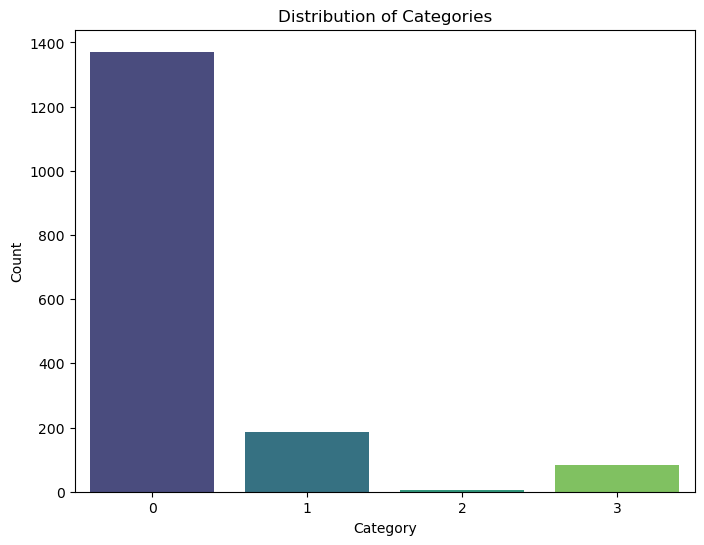

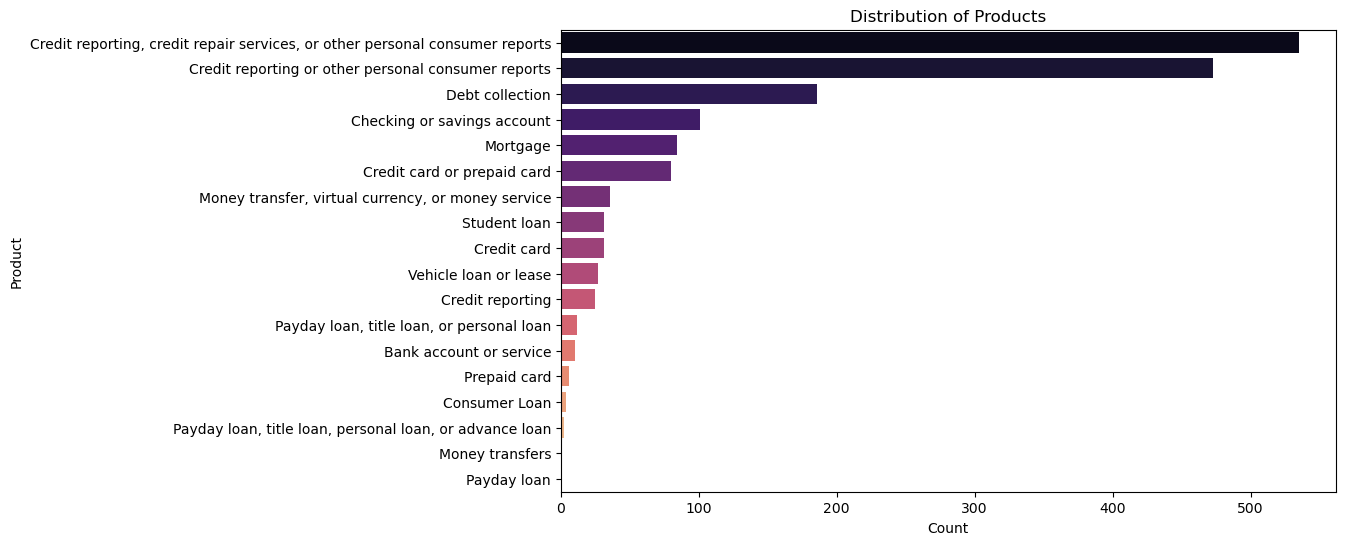

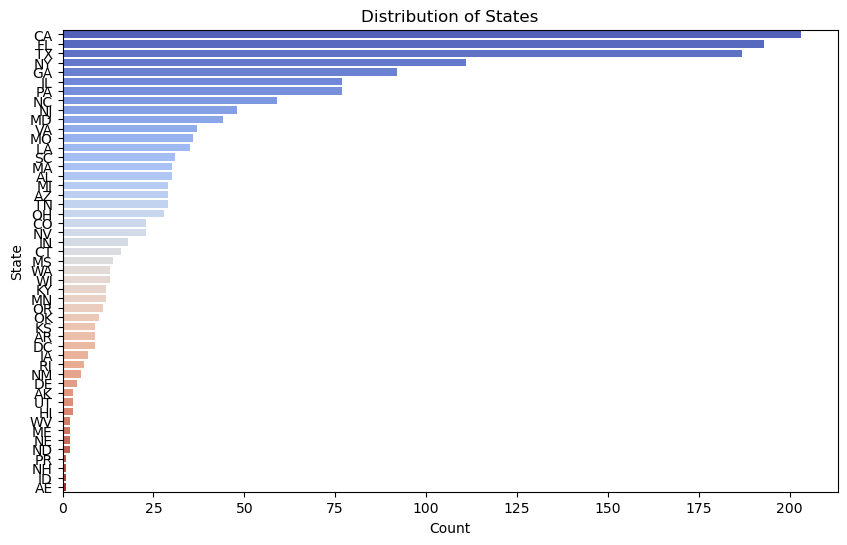

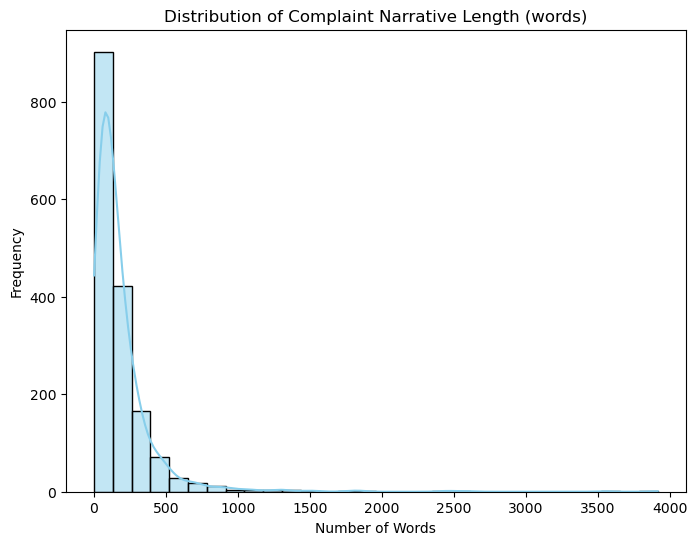

In [22]:
# Visual Exploratory Data Analysis

import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Categories
plt.figure(figsize=(8,6))
sns.countplot(x='Category', data=df, palette='viridis')
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

# Distribution of Products
plt.figure(figsize=(10,6))
sns.countplot(y='Product', data=df, order=df['Product'].value_counts().index, palette='magma')
plt.title('Distribution of Products')
plt.xlabel('Count')
plt.ylabel('Product')
plt.show()

# Distribution of States (if available)
if 'State' in df.columns:
    plt.figure(figsize=(10,6))
    sns.countplot(y='State', data=df, order=df['State'].value_counts().index, palette='coolwarm')
    plt.title('Distribution of States')
    plt.xlabel('Count')
    plt.ylabel('State')
    plt.show()

# Distribution of complaint narrative lengths (in words)
df['text_length'] = df['Consumer complaint narrative'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8,6))
sns.histplot(df['text_length'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Complaint Narrative Length (words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

## 3. Text Pre-Processing

We will clean the complaint narratives by:

- Converting text to lowercase
- Removing punctuation and numbers
- Removing stopwords
- Applying lemmatization

Let's define and apply the pre-processing function.

In [23]:
# Define text pre-processing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize the text
    tokens = text.split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

# Apply text pre-processing on the complaint narratives
df["Cleaned_Complaint"] = df["Consumer complaint narrative"].apply(preprocess_text)
df[["Consumer complaint narrative", "Cleaned_Complaint"]].head()

,Consumer complaint narrative,Cleaned_Complaint
3,In accordance with the Fair Credit Reporting a...,accordance fair credit reporting act list acco...
5,Although I have never been late on a payment w...,although never late payment xxxx since become ...
7,About 3 months ago I opened a secured account ...,month ago opened secured account xxxx card del...
9,I did not authorize these credit inquiries and...,authorize credit inquiry relationship company ...
11,I went to check my credit report on XX/XX/2017...,went check credit report xxxx found couple ite...


## 4. Feature Extraction

We convert the cleaned text data into numerical features using TF-IDF vectorization.

In [24]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df["Cleaned_Complaint"])

# Define the target variable
y = df["Category"]

print('Shape of TF-IDF matrix:', X.shape)

Shape of TF-IDF matrix: (1645, 5000)


## 5. Train-Test Split

We now split the dataset into training and testing sets.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Training set size:', X_train.shape)
print('Test set size:', X_test.shape)

Training set size: (1316, 5000)
Test set size: (329, 5000)


## 6. Model Selection and Hyperparameter Optimization

In this section we train and optimize several classifiers using GridSearchCV. We include the following models:

1. Logistic Regression
2. Multinomial Naive Bayes
3. Linear Support Vector Classifier (SVC)
4. Random Forest Classifier
5. Gradient Boosting Classifier
6. Multi-layer Perceptron (MLP) Classifier

For each model, we perform grid search to find optimal hyperparameters.

In [26]:
### 6.1 Logistic Regression
lr_params = {
    "C": [0.1, 1, 10],
    "penalty": ["l2"]
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=5, n_jobs=-1, scoring='accuracy')
grid_lr.fit(X_train, y_train)
print('Best LR parameters:', grid_lr.best_params_)

lr_best = grid_lr.best_estimator_
lr_pred = lr_best.predict(X_test)
print('Logistic Regression Accuracy:', accuracy_score(y_test, lr_pred))
print('\nClassification Report for Logistic Regression:\n', classification_report(y_test, lr_pred))

Best LR parameters: {'C': 10, 'penalty': 'l2'}
Logistic Regression Accuracy: 0.8693009118541033

Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       270
           1       0.79      0.46      0.58        41
           2       0.00      0.00      0.00         2
           3       0.55      0.38      0.44        16

    accuracy                           0.87       329
   macro avg       0.56      0.45      0.49       329
weighted avg       0.85      0.87      0.85       329



In [27]:
### 6.2 Multinomial Naive Bayes
nb_params = {"alpha": [0.1, 0.5, 1.0]}
grid_nb = GridSearchCV(MultinomialNB(), nb_params, cv=5, n_jobs=-1, scoring='accuracy')
grid_nb.fit(X_train, y_train)
print('Best NB parameters:', grid_nb.best_params_)

nb_best = grid_nb.best_estimator_
nb_pred = nb_best.predict(X_test)
print('Multinomial NB Accuracy:', accuracy_score(y_test, nb_pred))
print('\nClassification Report for Multinomial NB:\n', classification_report(y_test, nb_pred))

Best NB parameters: {'alpha': 0.1}
Multinomial NB Accuracy: 0.8571428571428571

Classification Report for Multinomial NB:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92       270
           1       0.82      0.22      0.35        41
           2       0.00      0.00      0.00         2
           3       0.64      0.56      0.60        16

    accuracy                           0.86       329
   macro avg       0.58      0.44      0.47       329
weighted avg       0.85      0.86      0.83       329



In [28]:
### 6.3 Linear SVC
svc_params = {"C": [0.1, 1, 10]}
grid_svc = GridSearchCV(LinearSVC(), svc_params, cv=5, n_jobs=-1, scoring='accuracy')
grid_svc.fit(X_train, y_train)
print('Best SVC parameters:', grid_svc.best_params_)

svc_best = grid_svc.best_estimator_
svc_pred = svc_best.predict(X_test)
print('Linear SVC Accuracy:', accuracy_score(y_test, svc_pred))
print('\nClassification Report for Linear SVC:\n', classification_report(y_test, svc_pred))

Best SVC parameters: {'C': 1}
Linear SVC Accuracy: 0.8723404255319149

Classification Report for Linear SVC:
               precision    recall  f1-score   support

           0       0.89      0.96      0.93       270
           1       0.76      0.46      0.58        41
           2       0.00      0.00      0.00         2
           3       0.62      0.50      0.55        16

    accuracy                           0.87       329
   macro avg       0.57      0.48      0.51       329
weighted avg       0.86      0.87      0.86       329



In [29]:
### 6.4 Random Forest Classifier
rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20]
}
grid_rf = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, n_jobs=-1, scoring='accuracy')
grid_rf.fit(X_train, y_train)
print('Best RF parameters:', grid_rf.best_params_)

rf_best = grid_rf.best_estimator_
rf_pred = rf_best.predict(X_test)
print('Random Forest Accuracy:', accuracy_score(y_test, rf_pred))
print('\nClassification Report for Random Forest:\n', classification_report(y_test, rf_pred))

Best RF parameters: {'max_depth': None, 'n_estimators': 200}
Random Forest Accuracy: 0.8601823708206687

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.87      0.99      0.92       270
           1       0.87      0.32      0.46        41
           2       0.00      0.00      0.00         2
           3       0.57      0.25      0.35        16

    accuracy                           0.86       329
   macro avg       0.58      0.39      0.43       329
weighted avg       0.85      0.86      0.83       329



In [30]:
### 6.5 Gradient Boosting Classifier
gb_params = {
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1, 0.2]
}
grid_gb = GridSearchCV(GradientBoostingClassifier(), gb_params, cv=5, n_jobs=-1, scoring='accuracy')
grid_gb.fit(X_train, y_train)
print('Best GB parameters:', grid_gb.best_params_)

gb_best = grid_gb.best_estimator_
gb_pred = gb_best.predict(X_test)
print('Gradient Boosting Accuracy:', accuracy_score(y_test, gb_pred))
print('\nClassification Report for Gradient Boosting:\n', classification_report(y_test, gb_pred))

Best GB parameters: {'learning_rate': 0.2, 'n_estimators': 100}
Gradient Boosting Accuracy: 0.8662613981762918

Classification Report for Gradient Boosting:
               precision    recall  f1-score   support

           0       0.90      0.95      0.93       270
           1       0.66      0.46      0.54        41
           2       0.00      0.00      0.00         2
           3       0.67      0.62      0.65        16

    accuracy                           0.87       329
   macro avg       0.56      0.51      0.53       329
weighted avg       0.86      0.87      0.86       329



In [31]:
### 6.6 Multi-layer Perceptron (MLP) Classifier
mlp_params = {
    "hidden_layer_sizes": [(50,), (100,), (50,50)],
    "activation": ['relu', 'tanh'],
    "max_iter": [300, 500]
}
grid_mlp = GridSearchCV(MLPClassifier(), mlp_params, cv=5, n_jobs=-1, scoring='accuracy')
grid_mlp.fit(X_train, y_train)
print('Best MLP parameters:', grid_mlp.best_params_)

mlp_best = grid_mlp.best_estimator_
mlp_pred = mlp_best.predict(X_test)
print('MLP Accuracy:', accuracy_score(y_test, mlp_pred))
print('\nClassification Report for MLP:\n', classification_report(y_test, mlp_pred))

Best MLP parameters: {'activation': 'relu', 'hidden_layer_sizes': (50, 50), 'max_iter': 500}
MLP Accuracy: 0.8541033434650456

Classification Report for MLP:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92       270
           1       0.71      0.41      0.52        41
           2       0.00      0.00      0.00         2
           3       0.47      0.44      0.45        16

    accuracy                           0.85       329
   macro avg       0.52      0.45      0.47       329
weighted avg       0.84      0.85      0.84       329



## 7. Model Comparison Summary

Below is a summary of the test accuracies for all optimized models.

                 Model  Accuracy
2           Linear SVC  0.872340
0  Logistic Regression  0.869301
4    Gradient Boosting  0.866261
3        Random Forest  0.860182
1       Multinomial NB  0.857143
5                  MLP  0.854103


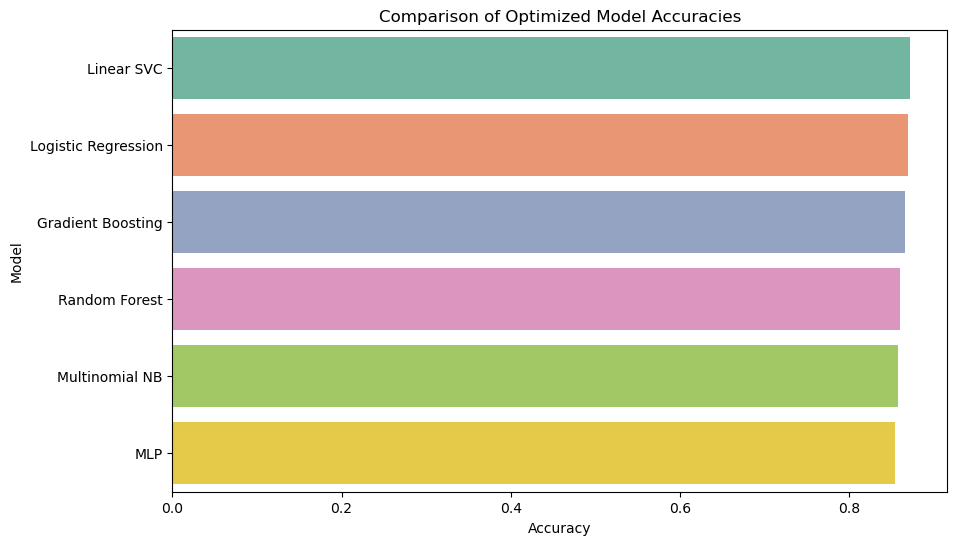

In [32]:
# Collect the accuracies
models = ['Logistic Regression', 'Multinomial NB', 'Linear SVC', 'Random Forest', 'Gradient Boosting', 'MLP']
accuracies = [
    accuracy_score(y_test, lr_pred),
    accuracy_score(y_test, nb_pred),
    accuracy_score(y_test, svc_pred),
    accuracy_score(y_test, rf_pred),
    accuracy_score(y_test, gb_pred),
    accuracy_score(y_test, mlp_pred)
]

summary_df = pd.DataFrame({'Model': models, 'Accuracy': accuracies})
print(summary_df.sort_values(by='Accuracy', ascending=False))

# Visualize the performance
plt.figure(figsize=(10,6))
sns.barplot(x='Accuracy', y='Model', data=summary_df.sort_values(by='Accuracy', ascending=False), palette='Set2')
plt.title('Comparison of Optimized Model Accuracies')
plt.show()

## 8. Evaluation: Confusion Matrix for the Best Model

Here we display the confusion matrix for the best performing model (based on accuracy). You may change the model if desired.

Best Model: Linear SVC


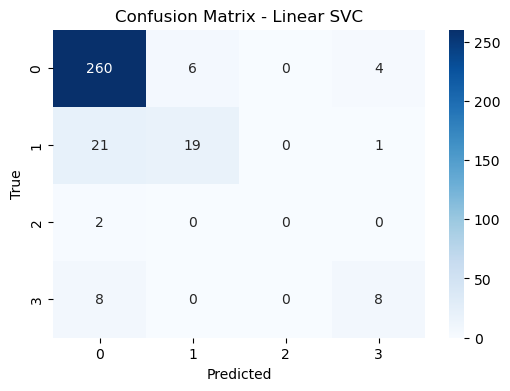

In [33]:
# Identify the best model by accuracy
best_model_index = np.argmax(accuracies)
best_model_name = models[best_model_index]

# Map best model to its predictions
model_predictions = [lr_pred, nb_pred, svc_pred, rf_pred, gb_pred, mlp_pred]
best_pred = model_predictions[best_model_index]

print('Best Model:', best_model_name)

cm = confusion_matrix(y_test, best_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - ' + best_model_name)
plt.show()

## 9. Prediction on New Data

Let's test the optimized pipeline on a new complaint narrative. The sample text is pre-processed, vectorized, and then a prediction is made using (for example) the best tuned Logistic Regression model. You can change the model for prediction if desired.

In [34]:
# Sample complaint narrative
sample_text = "I was denied a loan due to an error in my credit report, and the company's response was unsatisfactory."

# Preprocess the sample text
clean_sample = preprocess_text(sample_text)
sample_vect = tfidf.transform([clean_sample])

# For demonstration, using the best tuned Logistic Regression model (lr_best)
predicted_category = lr_best.predict(sample_vect)[0]

category_mapping = {
    0: 'Credit reporting, repair, or other',
    1: 'Debt collection',
    2: 'Consumer Loan',
    3: 'Mortgage'
}

print('Predicted Category:', category_mapping[predicted_category])

Predicted Category: Credit reporting, repair, or other
